### 1. DETECTAR LOCALITZACIÓ MATRICULA

In [48]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [49]:
# carregar el model yolo entrenat 
model = YOLO("/Users/carlotacortes/Desktop/PSIV/modelentrenat20/weights/best.pt")

# path imatge(s) que vull predir
image_path = "/Users/carlotacortes/Desktop/PSIV/matricules_profe/img_profe7.jpg"

#fer la predicció
results = model.predict(image_path)


image 1/1 /Users/carlotacortes/Desktop/PSIV/matricules_profe/img_profe7.jpg: 384x640 1 License-Plate, 146.1ms
Speed: 3.2ms preprocess, 146.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Bounding Box: (858, 979), (1927, 1342)


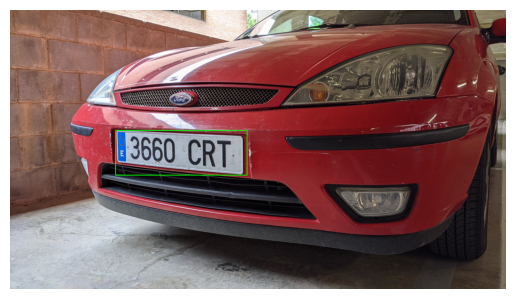

In [50]:
# iterar sobre els resultats i extreure info bounding box
for result in results:
    if hasattr(result, 'boxes'):  #tingui atribut boxes
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # extreure bonding box coordenades
            print(f"Bounding Box: ({x1}, {y1}), ({x2}, {y2})")

            # load image original
            image = cv2.imread(image_path)

            # dibuixar la bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 5)
        
        # mostrar imatge original amb rectangle
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("No bounding boxes found in this result.")

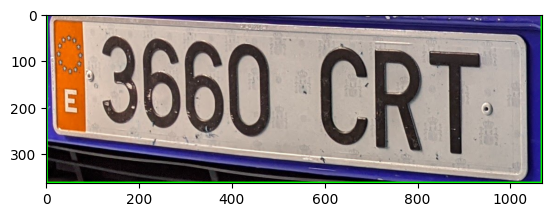

In [51]:
# extreure la matricula de la imateg original = ROI
roi = image[y1:y2, x1:x2] 
plt.imshow(roi)

### 2. SEGMENTAR MATRICULA

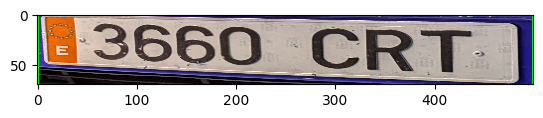

In [52]:
#definir els 4 corners basats en bounding box
top_left = (x1, y1)
top_right = (x2, y1)
bottom_right = (x2, y2)
bottom_left = (x1, y2)

# ordenar en source order
pts_src = np.array([top_left, top_right, bottom_right, bottom_left], dtype="float32")

# outout size dimensions
width, height = 500, 70  
pts_dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")

# matriu de transformacio perspectiva mitjançant punts source i output
M = cv2.getPerspectiveTransform(pts_src, pts_dst)

#aplicar transformacio 
warped_image = cv2.warpPerspective(image, M, (width, height))
plt.imshow(warped_image)
plt.show()

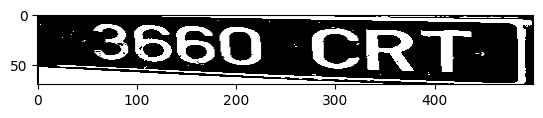

In [53]:
#passar a HSV === això ajuda a treure la E europea
image = cv2.cvtColor(warped_image, cv2.COLOR_BGR2HSV)
image = image[:, :, 2] #ens quedem amb la capa V
cv2.GaussianBlur(image, (5, 5), 0)
#threshold de otsu
thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) [1]
#invertir imatge
negative_image = 255 - thresh
plt.imshow(negative_image, cmap='gray')
plt.show()

Total contours found: 38
Contours after filtering: 7


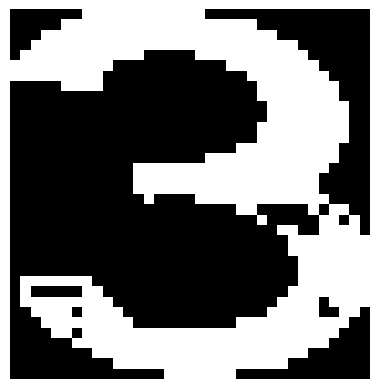

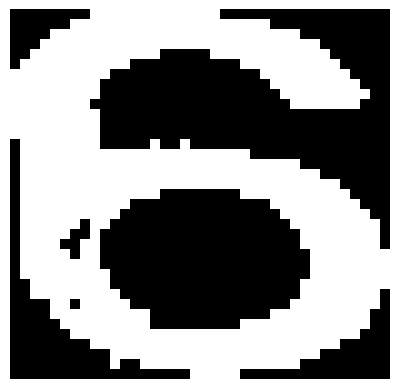

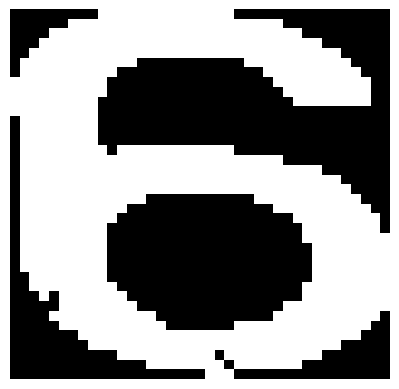

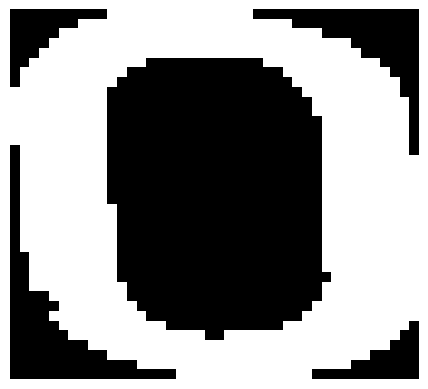

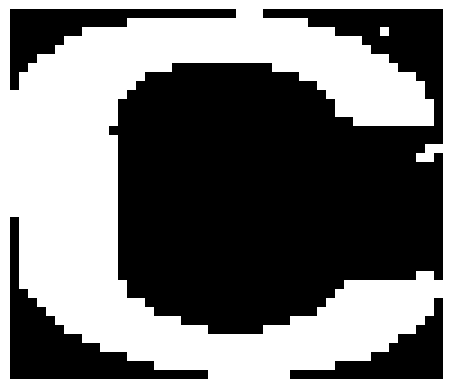

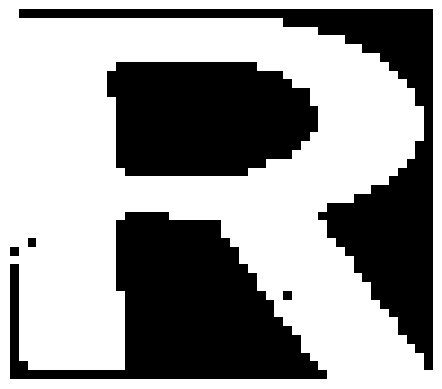

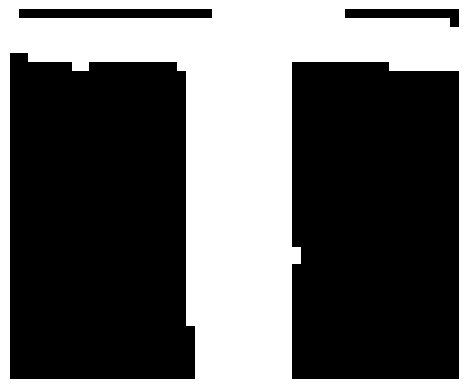

In [54]:
contours, _ = cv2.findContours(negative_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrar contours
character_contours = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / float(h)
    
    if 0.1 < aspect_ratio < 3.0 and 5 < w < 200 and 10 < h < 50:
        character_contours.append((x, y, w, h))

#ordenar 
character_contours = sorted(character_contours, key=lambda b: b[0])

#mostrar els caracters
if character_contours:
    for (x, y, w, h) in character_contours:
        char_image = negative_image[y:y + h, x:x + w]
        plt.imshow(char_image, cmap='gray')
        plt.axis('off')
        plt.show()
else:
    print("no contours found")
